In [16]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import pickle
import os
import missingno as msno
import shapely.io
from shapely.geometry import Point, LineString

from lxml import etree
from datetime import time

# Load GTFS data

https://github.com/matsim-org/matsim-libs/tree/master/examples/scenarios/pt-tutorial

## Shapes = edges

In [17]:
shapes_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/shapes.txt'

shapes = pd.read_csv(shapes_filename)
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,SHP_185_I,39.484123,-0.391542,0,0.0
1,SHP_185_I,39.485841,-0.390737,1,203.0
2,SHP_185_I,39.485841,-0.390737,2,203.0
3,SHP_185_I,39.487875,-0.389816,3,442.0
4,SHP_185_I,39.487875,-0.389816,4,442.0
...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0


In [18]:
shapes['geometry'] = shapes.apply(lambda row: Point(row['shape_pt_lon'], row['shape_pt_lat']), axis='columns')
shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (-0.39154151357175 39.4841225310996)
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (-0.390737093638577 39.4858407277057)
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (-0.390737093638577 39.4858407277057)
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (-0.389815625206019 39.4878754804054)
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (-0.389815625206019 39.4878754804054)
...,...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (-0.413260844324026 39.4697315368409)
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (-0.413268952564266 39.4697310416539)
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (-0.413271655644534 39.46973086759)
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0,POINT (-0.413919991912794 39.4696883517495)


In [19]:
edges = shapes.groupby('shape_id')['geometry'].apply(lambda x: LineString(x.to_list()))
edges = gpd.GeoDataFrame(edges, geometry='geometry')
edges = edges.set_crs('EPSG:4326')
edges

,geometry
shape_id,
SHP_1007_I,"LINESTRING (-0.41719 39.4684, -0.41737 39.4684..."
SHP_1007_V,"LINESTRING (-0.3457 39.47925, -0.34615 39.4782..."
SHP_1017_I,"LINESTRING (-0.3763 39.47061, -0.37613 39.4703..."
SHP_1017_V,"LINESTRING (-0.33179 39.44742, -0.33195 39.447..."
SHP_1018_I,"LINESTRING (-0.37837 39.46796, -0.3785 39.468,..."
...,...
SHP_995_V,"LINESTRING (-0.40417 39.49014, -0.40409 39.490..."
SHP_996_I,"LINESTRING (-0.38776 39.48015, -0.38804 39.480..."
SHP_996_V,"LINESTRING (-0.35594 39.47516, -0.35588 39.475..."


<Axes: >

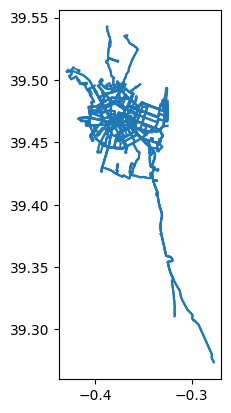

In [20]:
edges.plot()

In [21]:
if not os.path.exists('data/redes/bus/emt_shp/'):
    os.mkdir('data/redes/bus/emt_shp/')

edges.to_file('data/redes/bus/emt_shp/emt_edges.shp', driver='ESRI Shapefile')

## Stops

In [22]:
stops_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/stops.txt'

stops = pd.read_csv(stops_filename)
stops

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,10,10,Doctor Lluch - Mediterrània,C DOCTOR LLUCH 99 (DAVANT) - VALÈNCIA,39.467234,-0.328306,NaN,NaN,0,NaN
1,1007,1007,Jesús Morante Borrás (I),AV JESUS MORANTE BORRAS 26 - VALÈNCIA,39.451015,-0.345435,NaN,NaN,0,NaN
2,1008,1008,Jesús Morante Borrás (II),AV JESUS MORANTE BORRAS 54 - VALÈNCIA,39.449483,-0.344468,NaN,NaN,0,NaN
3,1009,1009,Jesús Morante Borrás (III),AV JESUS MORANTE BORRAS 86 - VALÈNCIA,39.447905,-0.344029,NaN,NaN,0,NaN
4,1010,1010,Jesús Morante Borrás (IV),AV JESUS MORANTE BORRAS 158 - VALÈNCIA,39.444148,-0.343987,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...
1141,978,978,Carters (parell) - Primer de Maig,C CARTEROS 84 - VALÈNCIA,39.448198,-0.389623,NaN,NaN,0,NaN
1142,979,979,Carters - Mossén Febrer,C CARTEROS 60 (DAVANT) - VALÈNCIA,39.450171,-0.388974,NaN,NaN,0,NaN
1143,983,983,Ramón y Cajal - Bailén,GV RAMON Y CAJAL 1 - VALÈNCIA,39.463089,-0.379623,NaN,NaN,0,NaN
1144,985,985,Centre de Salut Benimaclet,C JAIME ESTEVE CUBELLS 6 - VALÈNCIA,39.483322,-0.358504,NaN,NaN,0,NaN


In [23]:
stops['geometry'] = stops.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis='columns')

<Axes: >

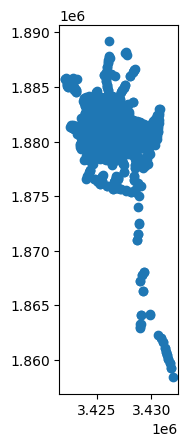

In [24]:
stops = gpd.GeoDataFrame(stops, geometry='geometry', crs='EPSG:4326')
stops = stops.to_crs('EPSG:3035')
stops.plot()

In [25]:
# if not os.path.exists('data/redes/bus/emt_shp/'):
#     os.mkdir('data/redes/bus/emt_shp/')
# 
# stops.to_file('data/redes/bus/emt_shp/emt_nodes.shp', driver='ESRI Shapefile')

## Routes

In [26]:
routes_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/routes.txt'

routes = pd.read_csv(routes_filename)
routes

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,23,EMT,23,POBLES DEL SUD,NaN,3,NaN,FE0000,FFFFFF
1,24,EMT,24,PORTA DE LA MAR - EL SALER / EL PALMAR,NaN,3,NaN,FE0000,FFFFFF
2,5,EMT,C1,CENTRE HISTÒRIC,NaN,3,NaN,FE0000,FFFFFF
3,63,EMT,63,CAMPUS DE BURJASSOT - ESTACIÓ DEL NORD,NaN,3,NaN,FE0000,FFFFFF
4,28,EMT,28,CIUTAT ART. FALLER - ESTACIÓ DEL NORD,NaN,3,NaN,FE0000,FFFFFF
5,95,EMT,95,JARDÍ DEL TÚRIA,NaN,3,NaN,FE0000,FFFFFF
6,4,EMT,4,PORT/NATZARET - POETA QUEROL,NaN,3,NaN,FE0000,FFFFFF
7,6,EMT,6,TORREFIEL - HOSPITAL LA FE,NaN,3,NaN,FE0000,FFFFFF
8,7,EMT,7,MERCAT CENTRAL - FTA. SANT LLUÍS,NaN,3,NaN,FE0000,FFFFFF
9,8,EMT,8,PORTA DE LA MAR - HOSPITAL LA FE,NaN,3,NaN,FE0000,FFFFFF


## Trips

In [27]:
trips_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/trips.txt'

trips = pd.read_csv(trips_filename)
trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,23,FES,1033D2V0,Porta de la Mar,0,10332,SHP_1033_V
1,23,FES,1033D2V1,Forn d'Alcedo,0,10332,SHP_1033_I
2,23,FES,1033D2V2,Porta de la Mar,0,10332,SHP_1033_V
3,23,FES,1033D2V3,Forn d'Alcedo,0,10332,SHP_1033_I
4,23,FES,1033D2V4,Porta de la Mar,0,10332,SHP_1033_V
...,...,...,...,...,...,...,...
2365,93,FES,994D2V,Av. del Cid,0,9942,SHP_994_V
2366,93,LAB,994D0I,Passeig Maritim,0,9940,SHP_994_I
2367,93,LAB,994D0V,Av. del Cid,0,9940,SHP_994_V
2368,93,SAB,994D1I,Passeig Maritim,0,9941,SHP_994_I


In [28]:
trips.loc[trips['trip_id'].eq('968D0V53')]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
337,63,LAB,968D0V53,Estació del Nord,0,9680,SHP_968_V


In [29]:
trips['trip_id'].nunique()

2370

## Frequencies

In [30]:
frequencies_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/frequencies.txt'

frequencies = pd.read_csv(frequencies_filename)
frequencies

,trip_id,start_time,end_time,headway_secs
0,1018D2I,6:00:00,6:25:00,1500
1,1018D2I,6:25:00,7:26:00,1220
2,1018D2I,7:26:00,20:44:00,591
3,1018D2I,20:44:00,22:00:00,900
4,1018D2V,6:17:00,6:42:00,1500
...,...,...,...,...
1553,994D1I,23:20:00,27:05:00,1714
1554,994D1V,5:30:00,6:10:00,2400
1555,994D1V,6:10:00,7:12:00,1860
1556,994D1V,7:12:00,23:10:00,912


In [31]:
frequencies['start_time'] = frequencies['start_time'].astype('timedelta64[s]')
frequencies['end_time'] = frequencies['end_time'].astype('timedelta64[s]')
frequencies

,trip_id,start_time,end_time,headway_secs
0,1018D2I,0 days 06:00:00,0 days 06:25:00,1500
1,1018D2I,0 days 06:25:00,0 days 07:26:00,1220
2,1018D2I,0 days 07:26:00,0 days 20:44:00,591
3,1018D2I,0 days 20:44:00,0 days 22:00:00,900
4,1018D2V,0 days 06:17:00,0 days 06:42:00,1500
...,...,...,...,...
1553,994D1I,0 days 23:20:00,1 days 03:05:00,1714
1554,994D1V,0 days 05:30:00,0 days 06:10:00,2400
1555,994D1V,0 days 06:10:00,0 days 07:12:00,1860
1556,994D1V,0 days 07:12:00,0 days 23:10:00,912


In [32]:
# test_range = pd.timedelta_range(start=pd.to_timedelta('0 days 07:42:00'), 
#                    end=pd.to_timedelta('0 days 20:35:00'), 
#                    freq='595s', 
#                    closed='left')
# test_range

## Stop times

In [33]:
stop_times_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/stop_times.txt'

stop_times = pd.read_csv(stop_times_filename)
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN


In [34]:
# assuming only on departure time
stop_times_departures = stop_times.groupby('trip_id')[['arrival_time', 'departure_time']].first().reset_index()

In [35]:
# convert arrivals and departures to timedelta (what happens when we go over 1 day?)
stop_times_departures['arrival_time'] = stop_times_departures['arrival_time'].astype('timedelta64[s]')
stop_times_departures['departure_time'] = stop_times_departures['departure_time'].astype('timedelta64[s]')


stop_times_departures = stop_times_departures.rename(columns={'arrival_time': 'arrival_time_original'})
stop_times_departures = stop_times_departures.rename(columns={'departure_time': 'departure_time_original'})
stop_times_departures

,trip_id,arrival_time_original,departure_time_original
0,1007D0I,0 days,0 days
1,1007D0V,0 days,0 days
2,1007D1I,0 days,0 days
3,1007D1V,0 days,0 days
4,1007D2I,0 days,0 days
...,...,...,...
2365,997D0V,0 days,0 days
2366,997D1I,0 days,0 days
2367,997D1V,0 days,0 days
2368,997D2I,0 days,0 days


In [36]:
# merging stop_times with stop_times_departures -> copies of first row arrival and departure times in front of every stop in the trip
stop_times_merged = stop_times.merge(stop_times_departures, on='trip_id', how='left')
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00
...,...,...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00


In [37]:
# adding a boolean flag if the trip is in frequencies.txt
stop_times_merged['is_relative'] = stop_times_merged['trip_id'].isin(frequencies['trip_id'])
stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original,is_relative
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,True
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,True
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,True
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,True


In [38]:
# define a helper function for timestamp to str conversion
def timedelta_to_str(timedelta):
    return f"{int(timedelta.total_seconds() // 3600):02}:{int((timedelta.total_seconds() % 3600) // 60):02}:{int(timedelta.total_seconds() % 60):02}"

In [39]:
# substracting first row arrival time from arrival times of all stops -> relative arrivals
stop_times_merged['arrival_time_offset'] = stop_times_merged['arrival_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time_original']
# substracting first row arrival time from departure times of all stops -> relative departures
stop_times_merged['departure_time_offset'] = stop_times_merged['departure_time'].astype('timedelta64[s]') - stop_times_merged['arrival_time'].astype('timedelta64[s]')

# get string representations for MATSim
stop_times_merged['arrival_time_offset_str'] = stop_times_merged['arrival_time_offset'].apply(lambda x: timedelta_to_str(x))
stop_times_merged['departure_time_offset_str'] = stop_times_merged['departure_time_offset'].apply(lambda x: timedelta_to_str(x))

stop_times_merged

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival_time_original,departure_time_original,is_relative,arrival_time_offset,departure_time_offset,arrival_time_offset_str,departure_time_offset_str
0,1033D2V0,5:48:00,5:50:00,585,0,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:00:00,0 days 00:02:00,00:00:00,00:02:00
1,1033D2V0,5:50:27,5:50:27,907,1,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:02:27,0 days 00:00:00,00:02:27,00:00:00
2,1033D2V0,5:50:42,5:50:42,1771,2,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:02:42,0 days 00:00:00,00:02:42,00:00:00
3,1033D2V0,5:51:11,5:51:11,1772,3,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:03:11,0 days 00:00:00,00:03:11,00:00:00
4,1033D2V0,5:52:57,5:52:57,912,4,NaN,0,0,NaN,0 days 05:48:00,0 days 05:50:00,False,0 days 00:04:57,0 days 00:00:00,00:04:57,00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66627,994D1V,0:28:30,0:28:30,484,23,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,True,0 days 00:28:30,0 days 00:00:00,00:28:30,00:00:00
66628,994D1V,0:29:21,0:29:21,485,24,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,True,0 days 00:29:21,0 days 00:00:00,00:29:21,00:00:00
66629,994D1V,0:31:34,0:31:34,486,25,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,True,0 days 00:31:34,0 days 00:00:00,00:31:34,00:00:00
66630,994D1V,0:32:22,0:32:22,487,26,NaN,0,0,NaN,0 days 00:00:00,0 days 00:00:00,True,0 days 00:32:22,0 days 00:00:00,00:32:22,00:00:00


## Calendar

In [40]:
calendar_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/calendar.txt'

calendar = pd.read_csv(calendar_filename, parse_dates=['start_date', 'end_date'])
calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,LAB,1,1,1,1,1,0,0,2024-01-01,2026-12-31
1,SAB,0,0,0,0,0,1,0,2024-01-01,2026-12-31
2,FES,0,0,0,0,0,0,1,2024-01-01,2026-12-31
3,NLAB,1,1,1,0,0,0,1,2024-01-01,2026-12-31
4,NFS,0,0,0,1,1,1,0,2024-01-01,2026-12-31
5,L38-755,1,1,1,1,1,1,1,2024-01-01,2026-12-31
6,L38-810,1,1,1,1,1,1,1,2024-01-01,2026-12-31
7,VLAB,1,1,1,1,1,0,0,2024-06-15,2024-09-29
8,VSAB,0,0,0,0,0,1,0,2024-06-15,2024-09-29
9,VFES,0,0,0,0,0,0,1,2024-06-15,2024-09-29


## Calendar dates

In [41]:
calendar_dates_filename = 'data/redes/bus/20241211_010133_EMT_Valencia/calendar_dates.txt'

calendar_dates = pd.read_csv(calendar_dates_filename, parse_dates=['date'])
calendar_dates

,service_id,date,exception_type
0,LAB,2024-01-22,2
1,FES,2024-01-22,1
2,LAB,2025-01-01,2
3,FES,2025-01-01,1
4,LAB,2025-01-06,2
...,...,...,...
81,NFES,2024-04-30,1
82,NLAB,2024-10-08,2
83,NFES,2024-10-08,1
84,NLAB,2024-12-24,2


In [42]:
shapes.shape

(29321, 6)

# Prepare MATSim configs

## Create nodes

Nodes are created from `shapes.txt` geometry column

In [43]:
nodes = shapes.copy()
nodes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (-0.39154151357175 39.4841225310996)
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (-0.390737093638577 39.4858407277057)
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (-0.390737093638577 39.4858407277057)
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (-0.389815625206019 39.4878754804054)
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (-0.389815625206019 39.4878754804054)
...,...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (-0.413260844324026 39.4697315368409)
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (-0.413268952564266 39.4697310416539)
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (-0.413271655644534 39.46973086759)
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0,POINT (-0.413919991912794 39.4696883517495)


In [44]:
nodes['node_id'] = nodes['shape_id'] + '_' + nodes['shape_pt_sequence'].astype('str')

In [45]:
nodes = gpd.GeoDataFrame(nodes, geometry='geometry', crs='EPSG:4326')

# convert to EPSG:3035 coordinates
nodes = nodes.to_crs('EPSG:3035')
nodes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,node_id
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (3424986.959 1882786.906),SHP_185_I_0
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (3425079.372 1882965.869),SHP_185_I_1
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (3425079.372 1882965.869),SHP_185_I_2
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (3425186.141 1883178.173),SHP_185_I_3
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (3425186.141 1883178.173),SHP_185_I_4
...,...,...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (3422929.833 1881464.864),SHP_1055_V_256
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (3422929.131 1881464.906),SHP_1055_V_257
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (3422928.898 1881464.919),SHP_1055_V_258
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0,POINT (3422872.794 1881467.914),SHP_1055_V_259


## Create edges

Edges are created as LineString objects connecting every 2 consecutive points.

In [354]:
# get current and next points' data on the same row
nodes['geometry_shifted'] = nodes.groupby('shape_id')['geometry'].shift(-1)
nodes['shape_dist_traveled_shifted'] = nodes.groupby('shape_id')['shape_dist_traveled'].shift(-1)
nodes['node_id_shifted'] = nodes.groupby('shape_id')['node_id'].shift(-1)

In [355]:
print(nodes.shape[0])
edges = nodes.dropna(subset=['geometry_shifted'])
print(edges.shape[0])

29321
29227


In [356]:
# rename columns to match MATSim attributes
edges = edges.rename(columns={'node_id':'from_node_id'})
edges = edges.rename(columns={'node_id_shifted':'to_node_id'})

In [358]:
# convert point geometry to line geometry
edges['geometry'] = edges.apply(lambda row: LineString([row['geometry'], row['geometry_shifted']]), axis='columns')

# drop now useless `geometry_shifted` column
edges = edges.drop(columns='geometry_shifted')

KeyError: 'geometry_shifted'

In [359]:
edges['length'] = edges['shape_dist_traveled_shifted'] - edges['shape_dist_traveled']

In [360]:
edges = edges.drop(columns=['geometry_shifted', 'shape_dist_traveled_shifted', 'same_point'], errors='ignore')

In [361]:
edges = gpd.GeoDataFrame(edges, geometry='geometry', crs='EPSG:3035')
# edges = edges.to_crs('EPSG:3035')
edges

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,from_node_id,to_node_id,shared_node_id,length
0,SHP_185_I,39.484123,-0.391542,0,0.0,"LINESTRING (3424986.959 1882786.906, 3425079.3...",SHP_185_I_0,SHP_185_I_1,SHP_185_I_0_SHP_185_V_202_SHP_966_I_41_SHP_966...,203.0
1,SHP_185_I,39.485841,-0.390737,1,203.0,"LINESTRING (3425079.372 1882965.869, 3425079.3...",SHP_185_I_1,SHP_185_I_2,SHP_185_I_1_SHP_185_I_2_SHP_966_I_43_SHP_966_I_44,0.0
2,SHP_185_I,39.485841,-0.390737,2,203.0,"LINESTRING (3425079.372 1882965.869, 3425186.1...",SHP_185_I_2,SHP_185_I_3,SHP_185_I_1_SHP_185_I_2_SHP_966_I_43_SHP_966_I_44,239.0
3,SHP_185_I,39.487875,-0.389816,3,442.0,"LINESTRING (3425186.141 1883178.173, 3425186.1...",SHP_185_I_3,SHP_185_I_4,SHP_185_I_3_SHP_185_I_4_SHP_966_I_45_SHP_966_I...,0.0
4,SHP_185_I,39.487875,-0.389816,4,442.0,"LINESTRING (3425186.141 1883178.173, 3425202.9...",SHP_185_I_4,SHP_185_I_5,SHP_185_I_3_SHP_185_I_4_SHP_966_I_45_SHP_966_I...,33.0
...,...,...,...,...,...,...,...,...,...,...
29315,SHP_1055_V,39.469845,-0.411546,255,9569.0,"LINESTRING (3423078.228 1881457.069, 3422929.8...",SHP_1055_V_255,SHP_1055_V_256,SHP_1054_V_260_SHP_1054_V_261_SHP_1055_V_254_S...,148.0
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,"LINESTRING (3422929.833 1881464.864, 3422929.1...",SHP_1055_V_256,SHP_1055_V_257,SHP_1054_V_262_SHP_1055_V_256_SHP_994_V_395,1.0
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,"LINESTRING (3422929.131 1881464.906, 3422928.8...",SHP_1055_V_257,SHP_1055_V_258,SHP_1054_V_263_SHP_1055_V_257_SHP_994_V_396,0.0
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,"LINESTRING (3422928.898 1881464.919, 3422872.7...",SHP_1055_V_258,SHP_1055_V_259,SHP_1054_V_264_SHP_1055_V_258_SHP_994_V_397,56.0


## Input date

The date introduced is used to generate transit schedules for this day in particular.

`calendat.txt` and `calendar_dates.txt` are checked to filter the schedule.

In [362]:
date_to_check = pd.to_datetime('2024-08-23')

In [364]:
weekday_names = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

# define conditions to filter calendars 
condition_date_range = calendar['start_date'].le(date_to_check) & calendar['end_date'].ge(date_to_check)
condition_weekday = calendar[weekday_names[date_to_check.weekday()]].eq(1)

# preliminarly filter by conditions
relevant_service_ids = calendar.loc[condition_date_range & condition_weekday]
relevant_service_ids

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,LAB,1,1,1,1,1,0,0,2024-01-01,2026-12-31
4,NFS,0,0,0,1,1,1,0,2024-01-01,2026-12-31
5,L38-755,1,1,1,1,1,1,1,2024-01-01,2026-12-31
6,L38-810,1,1,1,1,1,1,1,2024-01-01,2026-12-31
7,VLAB,1,1,1,1,1,0,0,2024-06-15,2024-09-29


In [365]:
# finally filter according to the exceptions from calendar_dates.txt
if relevant_service_ids.shape[0] > 0:
    if date_to_check in calendar_dates['date'].values:
        service_ids_to_add = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), 'service_id']
        service_ids_to_delete = calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(2), 'service_id']
        
        
        # adding service ids
        relevant_service_ids = pd.concat([relevant_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_add), :]], axis='index')
        print(f'Added: {service_ids_to_add}')
        
        # removing service ids
        relevant_service_ids_merged = pd.merge(relevant_service_ids, calendar.loc[condition_date_range & calendar['service_id'].isin(service_ids_to_delete), :], how='left', indicator=True)
        relevant_service_ids = relevant_service_ids_merged.loc[relevant_service_ids_merged['_merge'].ne('both')].drop(columns='_merge')
        print(f'Deleted: {service_ids_to_delete}')
    else:
        print('No changes were made to the candidate list.')
else:
    if date_to_check in calendar_dates['date'].values:
        if calendar_dates.loc[calendar_dates['date'].eq(date_to_check) & calendar_dates['exception_type'].eq(1), :].shape[0] > 0:
            pass # add exception
    else:
        print('No service_id found for this date.')

No changes were made to the candidate list.


In [366]:
relevant_service_ids

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,LAB,1,1,1,1,1,0,0,2024-01-01,2026-12-31
4,NFS,0,0,0,1,1,1,0,2024-01-01,2026-12-31
5,L38-755,1,1,1,1,1,1,1,2024-01-01,2026-12-31
6,L38-810,1,1,1,1,1,1,1,2024-01-01,2026-12-31
7,VLAB,1,1,1,1,1,0,0,2024-06-15,2024-09-29


In [367]:
# shapes_to_check = ['SHP_970_V', 'SHP_970_I']
# 
# trips.loc[trips['service_id'].isin(relevant_service_ids['service_id']) & trips['shape_id'].isin(shapes_to_check),:]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
1501,72,LAB,970D0I,Sant Isidre,0,9700,SHP_970_I
1502,72,LAB,970D0V,Estació del Nord,0,9700,SHP_970_V


## Network to XML (`network.xml`)

In [161]:
# filter nodes and shapes for relevant shape_id values only
shape_id_to_use = trips.loc[trips['service_id'].isin(relevant_service_ids['service_id']), 'shape_id']

nodes_filtered = nodes.loc[nodes['shape_id'].isin(shape_id_to_use), :]
edges_filtered = edges.loc[edges['shape_id'].isin(shape_id_to_use), :]

nodes_filtered.shape, edges_filtered.shape

((28320, 11), (28230, 9))

In [162]:
edges_filtered.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,from_node_id,to_node_id,length
0,SHP_185_I,39.484123,-0.391542,0,0.0,"LINESTRING (3424986.959 1882786.906, 3425079.3...",SHP_185_I_0,SHP_185_I_1,203.0
1,SHP_185_I,39.485841,-0.390737,1,203.0,"LINESTRING (3425079.372 1882965.869, 3425079.3...",SHP_185_I_1,SHP_185_I_2,0.0
2,SHP_185_I,39.485841,-0.390737,2,203.0,"LINESTRING (3425079.372 1882965.869, 3425186.1...",SHP_185_I_2,SHP_185_I_3,239.0
3,SHP_185_I,39.487875,-0.389816,3,442.0,"LINESTRING (3425186.141 1883178.173, 3425186.1...",SHP_185_I_3,SHP_185_I_4,0.0
4,SHP_185_I,39.487875,-0.389816,4,442.0,"LINESTRING (3425186.141 1883178.173, 3425202.9...",SHP_185_I_4,SHP_185_I_5,33.0


In [163]:
# edges_filtered['base_shape_id'] = edges_filtered['shape_id'].str.rstrip(r'_I|_V')

edges_to_add = edges_filtered.groupby('shape_id')['to_node_id'].last()
edges_to_add = edges_to_add.reset_index()

edges_to_add['base_shape_id'] = edges_to_add['shape_id'].str.rstrip(r'_I|_V')

edges_to_add['is_v'] = edges_to_add['shape_id'].str.slice(-1).eq('V')
edges_to_add['is_i'] = edges_to_add['shape_id'].str.slice(-1).eq('I')


edges_to_add['from_node_id'] = edges_to_add.apply(lambda row: row['to_node_id'], axis='columns')
edges_to_add['to_node_id'] = edges_to_add.apply(lambda row: row['base_shape_id'] + '_I_' * row['is_v'] + '_V_' * row['is_i'] + '0', axis='columns')

edges_to_add.index = edges_to_add.index.astype(str) + 'X'
edges_to_add['length'] = 1

edges_to_add = edges_to_add.drop(columns=['base_shape_id', 'is_v', 'is_i'])

edges_to_add

,shape_id,to_node_id,from_node_id,length
0X,SHP_1007_I,SHP_1007_V_0,SHP_1007_I_534,1
1X,SHP_1007_V,SHP_1007_I_0,SHP_1007_V_428,1
2X,SHP_1017_I,SHP_1017_V_0,SHP_1017_I_393,1
3X,SHP_1017_V,SHP_1017_I_0,SHP_1017_V_477,1
4X,SHP_1018_I,SHP_1018_V_0,SHP_1018_I_99,1
...,...,...,...,...
85X,SHP_995_V,SHP_995_I_0,SHP_995_V_179,1
86X,SHP_996_I,SHP_996_V_0,SHP_996_I_257,1
87X,SHP_996_V,SHP_996_I_0,SHP_996_V_150,1
88X,SHP_997_I,SHP_997_V_0,SHP_997_I_199,1


In [164]:
edges_to_add.loc[edges_to_add['from_node_id'].eq('SHP_970_V_133')]

,shape_id,to_node_id,from_node_id,length
75X,SHP_970_V,SHP_970_I_0,SHP_970_V_133,1


In [165]:
# add artificial edges to the network
edges_filtered = pd.concat([edges_filtered, edges_to_add], axis='index')

In [166]:
version = 1
graph_to_load = 'v' + str(version)

In [167]:
root = etree.Element('network', name='emt_network_' + graph_to_load)

## GENERATING NODES

nodes_item = etree.SubElement(root, 'nodes')

for _, node in nodes_filtered.iterrows():

    nodes_item.append(etree.Element('node', 
                                    id=str(node['node_id']), 
                                    x=str(node['geometry'].coords.xy[0][0]), 
                                    y=str(node['geometry'].coords.xy[1][0])))


## GENERATING LINKS

links_item = etree.SubElement(root, 'links')

for _, link in edges_filtered.iterrows():

    from_node = link['from_node_id']
    to_node = link['to_node_id']
    
    link_item = etree.SubElement(links_item, 'link')

    link_item.set('id', str(_))
    link_item.set('from', str(from_node))
    link_item.set('to', str(to_node))
    link_item.set('freespeed', str(100))
    link_item.set('capacity', str(1000))
    link_item.set('permlanes', str(1))
    link_item.set('length', str(np.round(link['length'], 3)))


    link_item.set('modes', 'pt')

doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v1.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

with open('networks/network_' + graph_to_load + '.xml', 'wb') as file:
    file.write(final_xml)

In [56]:
shared_node_id = nodes.rename(columns={'node_id':'shared_node_id'}).groupby('geometry')['shared_node_id'].apply(pd.Series.to_list).apply(sorted).apply(lambda x: '_'.join(map(str, x))) 
shared_node_id

geometry
POINT (3423979.403 1876496.488)     SHP_860_I_190
POINT (3423976.253 1876497.258)     SHP_860_I_189
POINT (3423973.182 1876498.718)     SHP_860_I_188
POINT (3423972.5 1876501.087)       SHP_860_I_187
POINT (3423974.252 1876505.908)     SHP_860_I_186
                                        ...      
POINT (3431966.508 1858373.638)    SHP_1026_I_434
POINT (3431967.659 1858371.858)    SHP_1026_I_433
POINT (3431968.05 1858369.427)     SHP_1026_I_432
POINT (3431967.414 1858366.841)    SHP_1026_I_431
POINT (3431966.227 1858364.725)    SHP_1026_I_430
Name: shared_node_id, Length: 16451, dtype: object

In [57]:
nodes = nodes.merge(shared_node_id, on='geometry')
nodes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,node_id,geometry_shifted,shape_dist_traveled_shifted,node_id_shifted,shared_node_id
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (3424986.959 1882786.906),SHP_185_I_0,POINT (3425079.372 1882965.869),203.0,SHP_185_I_1,SHP_185_I_0_SHP_185_V_202_SHP_966_I_41_SHP_966...
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (3425079.372 1882965.869),SHP_185_I_1,POINT (3425079.372 1882965.869),203.0,SHP_185_I_2,SHP_185_I_1_SHP_185_I_2_SHP_966_I_43_SHP_966_I_44
2,SHP_185_I,39.485841,-0.390737,2,203.0,POINT (3425079.372 1882965.869),SHP_185_I_2,POINT (3425186.141 1883178.173),442.0,SHP_185_I_3,SHP_185_I_1_SHP_185_I_2_SHP_966_I_43_SHP_966_I_44
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (3425186.141 1883178.173),SHP_185_I_3,POINT (3425186.141 1883178.173),442.0,SHP_185_I_4,SHP_185_I_3_SHP_185_I_4_SHP_966_I_45_SHP_966_I...
4,SHP_185_I,39.487875,-0.389816,4,442.0,POINT (3425186.141 1883178.173),SHP_185_I_4,POINT (3425202.937 1883205.247),475.0,SHP_185_I_5,SHP_185_I_3_SHP_185_I_4_SHP_966_I_45_SHP_966_I...
...,...,...,...,...,...,...,...,...,...,...,...
29316,SHP_1055_V,39.469732,-0.413261,256,9717.0,POINT (3422929.833 1881464.864),SHP_1055_V_256,POINT (3422929.131 1881464.906),9718.0,SHP_1055_V_257,SHP_1054_V_262_SHP_1055_V_256_SHP_994_V_395
29317,SHP_1055_V,39.469731,-0.413269,257,9718.0,POINT (3422929.131 1881464.906),SHP_1055_V_257,POINT (3422928.898 1881464.919),9718.0,SHP_1055_V_258,SHP_1054_V_263_SHP_1055_V_257_SHP_994_V_396
29318,SHP_1055_V,39.469731,-0.413272,258,9718.0,POINT (3422928.898 1881464.919),SHP_1055_V_258,POINT (3422872.794 1881467.914),9774.0,SHP_1055_V_259,SHP_1054_V_264_SHP_1055_V_258_SHP_994_V_397
29319,SHP_1055_V,39.469688,-0.413920,259,9774.0,POINT (3422872.794 1881467.914),SHP_1055_V_259,POINT (3422872.507 1881467.93),9774.0,SHP_1055_V_260,SHP_1054_I_0_SHP_1054_V_265_SHP_1055_I_0_SHP_1...


In [58]:
nodes.drop_duplicates(subset='shared_node_id')

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry,node_id,geometry_shifted,shape_dist_traveled_shifted,node_id_shifted,shared_node_id
0,SHP_185_I,39.484123,-0.391542,0,0.0,POINT (3424986.959 1882786.906),SHP_185_I_0,POINT (3425079.372 1882965.869),203.0,SHP_185_I_1,SHP_185_I_0_SHP_185_V_202_SHP_966_I_41_SHP_966...
1,SHP_185_I,39.485841,-0.390737,1,203.0,POINT (3425079.372 1882965.869),SHP_185_I_1,POINT (3425079.372 1882965.869),203.0,SHP_185_I_2,SHP_185_I_1_SHP_185_I_2_SHP_966_I_43_SHP_966_I_44
3,SHP_185_I,39.487875,-0.389816,3,442.0,POINT (3425186.141 1883178.173),SHP_185_I_3,POINT (3425186.141 1883178.173),442.0,SHP_185_I_4,SHP_185_I_3_SHP_185_I_4_SHP_966_I_45_SHP_966_I...
5,SHP_185_I,39.488139,-0.389662,5,475.0,POINT (3425202.937 1883205.247),SHP_185_I_5,POINT (3425202.937 1883205.247),475.0,SHP_185_I_6,SHP_185_I_5_SHP_185_I_6_SHP_966_I_47_SHP_966_I...
7,SHP_185_I,39.488306,-0.389590,7,494.0,POINT (3425211.386 1883222.744),SHP_185_I_7,POINT (3425229.252 1883245.905),524.0,SHP_185_I_8,SHP_185_I_7_SHP_966_I_49
...,...,...,...,...,...,...,...,...,...,...,...
28812,SHP_1054_V,39.470303,-0.405960,255,8972.0,POINT (3423562.907 1881441.289),SHP_1054_V_255,POINT (3423543.053 1881431.101),8994.0,SHP_1054_V_256,SHP_1054_V_255_SHP_1055_V_249
28813,SHP_1054_V,39.470187,-0.406173,256,8994.0,POINT (3423543.053 1881431.101),SHP_1054_V_256,POINT (3423530.866 1881427.735),9007.0,SHP_1054_V_257,SHP_1054_V_256_SHP_1055_V_250
28814,SHP_1054_V,39.470142,-0.406308,257,9007.0,POINT (3423530.866 1881427.735),SHP_1054_V_257,POINT (3423519.814 1881429.195),9018.0,SHP_1054_V_258,SHP_1054_V_257_SHP_1055_V_251
28815,SHP_1054_V,39.470141,-0.406437,258,9018.0,POINT (3423519.814 1881429.195),SHP_1054_V_258,POINT (3423444.511 1881438.146),9094.0,SHP_1054_V_259,SHP_1054_V_258_SHP_1055_V_252


## Map stops to edges

+ get `trip_id` (1) to `stop_id` (N) mapping -- `trips_to_stops`
+ get `shape_id` (1) to `stop_id` (N) mapping -- `shapes_to_stops`
+ get `stop_id` (1) to (`shape_id`, `shape_pt_sequence`) (1) mapping -- `shape_segments_to_stops`

In [341]:
trips.loc[trips['shape_id'].eq('SHP_1007_I')]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
1493,71,FES,1007D2I,Universitats,0,10072,SHP_1007_I
1495,71,LAB,1007D0I,Universitats,0,10070,SHP_1007_I
1497,71,SAB,1007D1I,Universitats,0,10071,SHP_1007_I


In [342]:
trips_to_stops = stop_times.groupby('trip_id')['stop_id'].apply(pd.Series.to_list)
trips_to_stops.loc['1007D0I']

[1366,
 2004,
 2005,
 2006,
 2007,
 1223,
 498,
 529,
 530,
 531,
 532,
 533,
 744,
 761,
 816,
 2210,
 2314,
 2280,
 2281,
 2257,
 1245,
 337,
 166,
 167,
 168,
 169,
 115,
 116,
 117,
 1096,
 1283,
 1282]

In [253]:
trips_merged = pd.merge(trips, trips_to_stops, on='trip_id', how='left')
trips_merged

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,stop_id
0,23,FES,1033D2V0,Porta de la Mar,0,10332,SHP_1033_V,"[585, 907, 1771, 1772, 912, 910, 664, 665, 128..."
1,23,FES,1033D2V1,Forn d'Alcedo,0,10332,SHP_1033_I,"[2251, 777, 1427, 1428, 1664, 1765, 2041, 2042..."
2,23,FES,1033D2V2,Porta de la Mar,0,10332,SHP_1033_V,"[585, 907, 1771, 1772, 912, 910, 664, 665, 128..."
3,23,FES,1033D2V3,Forn d'Alcedo,0,10332,SHP_1033_I,"[2251, 777, 1427, 1428, 1664, 1765, 2041, 2042..."
4,23,FES,1033D2V4,Porta de la Mar,0,10332,SHP_1033_V,"[585, 907, 1771, 1772, 912, 910, 664, 665, 128..."
...,...,...,...,...,...,...,...,...
2365,93,FES,994D2V,Av. del Cid,0,9942,SHP_994_V,"[2271, 1551, 1918, 1900, 1361, 1490, 1901, 190..."
2366,93,LAB,994D0I,Passeig Maritim,0,9940,SHP_994_I,"[488, 495, 496, 700, 506, 507, 508, 1254, 760,..."
2367,93,LAB,994D0V,Av. del Cid,0,9940,SHP_994_V,"[2271, 1551, 1918, 1900, 1361, 1490, 1901, 190..."
2368,93,SAB,994D1I,Passeig Maritim,0,9941,SHP_994_I,"[488, 495, 496, 700, 506, 507, 508, 1254, 760,..."


In [254]:
shapes_to_stops = trips_merged.groupby('shape_id')['stop_id'].first()
shapes_to_stops.head()

shape_id
SHP_1007_I    [1366, 2004, 2005, 2006, 2007, 1223, 498, 529,...
SHP_1007_V    [1282, 1114, 112, 113, 114, 154, 155, 158, 160...
SHP_1017_I    [2403, 2281, 2250, 2206, 1615, 1616, 1617, 161...
SHP_1017_V    [1585, 1981, 70, 1919, 1306, 1590, 1591, 1592,...
SHP_1018_I    [2277, 1520, 1766, 792, 793, 795, 796, 1305, 1...
Name: stop_id, dtype: object

In [353]:
# we do a walk along the shape assigning stops consecutively to avoid non-increasing shape_pt_sequence's...

test_gdf = gpd.GeoDataFrame()
shape_segments_to_stops = gpd.GeoDataFrame()

# iterating through shapes
for shape_id, stops_array in shapes_to_stops.items():
    
    # get only the relevant shape's segments
    shape_segments = edges.loc[edges['shape_id'].eq(shape_id), :]
    
    # get only the relevant shape's stops
    stops_filtered = stops.loc[stops['stop_id'].isin(stops_array), :]


    last_sequence_assigned = -1
    for _, stop in stops_filtered.iterrows():
        
        # the 
        stop_to_assign = stops.loc[stops['stop_id'].eq(stop['stop_id']), :]
        shape_segments_filtered = shape_segments.loc[shape_segments['shape_pt_sequence'].gt(last_sequence_assigned)]
        
        cross = pd.merge(shape_segments_filtered, stop_to_assign, how='cross', suffixes=['_shape', '_stop'])
        cross['distance'] = cross['geometry_stop'].distance(cross['geometry_shape'])
        cross['distance_diff'] = cross['distance'].diff().shift(-1).ge(0)
        
        segment_to_assign = cross.loc[cross['distance_diff'].eq(True)].head(1)
        
        test_gdf = pd.concat([test_gdf, segment_to_assign], axis='index')
        last_sequence_assigned = segment_to_assign['shape_pt_sequence'].iloc[0]
    

test_gdf

/Users/family/PycharmProjects/UPV/.venv/lib/python3.12/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/family/PycharmProjects/UPV/.venv/lib/python3.12/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/Users/family/PycharmProjects/UPV/.venv/lib/python3.12/site-packages/shapely/measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


KeyboardInterrupt: 

In [337]:
test_gdf

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,geometry_shape,from_node_id,to_node_id,length,stop_id,...,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,geometry_stop,distance,distance_diff
0,SHP_1007_I,39.468399,-0.417189,0,0.0,"LINESTRING (3422575.169 1881365.098, 3422560.4...",SHP_1007_I_0,SHP_1007_I_1,19.0,1096,...,C RAMON LLULL 31 (DAVANT) - VALÈNCIA,39.476994,-0.346259,NaN,NaN,0,NaN,POINT (3428766.961 1881472.543),6192.724111,True
0,SHP_1007_I,39.468490,-0.417375,1,19.0,"LINESTRING (3422560.466 1881377.265, 3422551.3...",SHP_1007_I_1,SHP_1007_I_2,10.0,115,...,AV BLASCO IBAÑEZ 84 (JARDÍ) - VALÈNCIA,39.474807,-0.351126,NaN,NaN,0,NaN,POINT (3428320.368 1881289.784),5760.566784,True
0,SHP_1007_I,39.468523,-0.417487,2,29.0,"LINESTRING (3422551.363 1881382.275, 3422540.4...",SHP_1007_I_2,SHP_1007_I_3,12.0,116,...,AV BLASCO IBAÑEZ 104 (JARDÍ) - VALÈNCIA,39.474152,-0.348999,NaN,NaN,0,NaN,POINT (3428493.562 1881192.951),5945.213909,True
0,SHP_1007_I,39.468539,-0.417617,3,41.0,"LINESTRING (3422540.445 1881385.573, 3422532.6...",SHP_1007_I_3,SHP_1007_I_4,9.0,117,...,C RAMON LLULL 6 - VALÈNCIA,39.475132,-0.347130,NaN,NaN,0,NaN,POINT (3428666.975 1881278.559),6127.464392,True
0,SHP_1007_I,39.468573,-0.417713,4,50.0,"LINESTRING (3422532.691 1881390.382, 3422529.7...",SHP_1007_I_4,SHP_1007_I_5,4.0,1223,...,AV TRES CRUCES 8 (CARRIL BUS) - VALÈNCIA,39.466976,-0.406337,NaN,NaN,0,NaN,POINT (3423484.991 1881080.855),1001.339848,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,SHP_997_V,39.465995,-0.381651,108,4264.0,"LINESTRING (3425585.693 1880682.27, 3425558.01...",SHP_997_V_108,SHP_997_V_109,75.0,693,...,GV FERNANDO EL CATOLICO 10 - VALÈNCIA,39.470257,-0.384685,NaN,NaN,0,NaN,POINT (3425384.183 1881185.476),466.474465,True
1,SHP_997_V,39.466591,-0.382069,110,4339.0,"LINESTRING (3425558.018 1880752.602, 3425528.8...",SHP_997_V_110,SHP_997_V_111,72.0,694,...,GV FERNANDO EL CATOLICO 36 - VALÈNCIA,39.472322,-0.386132,NaN,NaN,0,NaN,POINT (3425288.55 1881428.939),656.020578,True
1,SHP_997_V,39.467146,-0.382499,112,4411.0,"LINESTRING (3425528.858 1880818.518, 3425397.9...",SHP_997_V_112,SHP_997_V_113,348.0,695,...,GV FERNANDO EL CATOLICO 70 - VALÈNCIA,39.474943,-0.388011,NaN,NaN,0,NaN,POINT (3425163.488 1881738.569),640.566944,True
0,SHP_997_V,39.469889,-0.384466,113,4759.0,"LINESTRING (3425397.918 1881142.441, 3425397.9...",SHP_997_V_113,SHP_997_V_114,0.0,737,...,C SAN VICENTE MARTIR 188 (DAVANT) - VALÈNCIA,39.460698,-0.382702,NaN,NaN,0,NaN,POINT (3425423.17 1880113.738),1029.012807,True


In [266]:
shape_segments_to_stops = shape_segments_to_stops.reset_index().loc[:, ['stop_id', 'shape_id', 'shape_pt_sequence']].sort_values(by=['shape_id', 'shape_pt_sequence'])
shape_segments_to_stops

,stop_id,shape_id,shape_pt_sequence
22,1366,SHP_1007_I,0
23,2004,SHP_1007_I,16
24,2005,SHP_1007_I,30
25,2006,SHP_1007_I,39
26,2007,SHP_1007_I,45
...,...,...,...
2332,1848,SHP_997_V,247
2333,1849,SHP_997_V,250
2334,1850,SHP_997_V,254
2340,2389,SHP_997_V,260


In [64]:
shape_segments_to_stops['stop_id_by_shape'] = shape_segments_to_stops['stop_id'].astype('str') + '_' + shape_segments_to_stops['shape_id'].astype('str')
shape_segments_to_stops

,stop_id,shape_id,shape_pt_sequence,stop_id_by_shape
22,1366,SHP_1007_I,0,1366_SHP_1007_I
23,2004,SHP_1007_I,16,2004_SHP_1007_I
24,2005,SHP_1007_I,30,2005_SHP_1007_I
25,2006,SHP_1007_I,39,2006_SHP_1007_I
26,2007,SHP_1007_I,45,2007_SHP_1007_I
...,...,...,...,...
2332,1848,SHP_997_V,247,1848_SHP_997_V
2333,1849,SHP_997_V,250,1849_SHP_997_V
2334,1850,SHP_997_V,254,1850_SHP_997_V
2340,2389,SHP_997_V,260,2389_SHP_997_V


In [65]:
shape_segments_to_stops = pd.merge(shape_segments_to_stops, stops.to_crs(epsg=3035).loc[:, ['stop_id', 'geometry']], on='stop_id', how='left')
shape_segments_to_stops

,stop_id,shape_id,shape_pt_sequence,stop_id_by_shape,geometry
0,1366,SHP_1007_I,0,1366_SHP_1007_I,POINT (3422579.404 1881371.058)
1,2004,SHP_1007_I,16,2004_SHP_1007_I,POINT (3422793.435 1881418.538)
2,2005,SHP_1007_I,30,2005_SHP_1007_I,POINT (3422796.395 1881231.847)
3,2006,SHP_1007_I,39,2006_SHP_1007_I,POINT (3422949.297 1881156.373)
4,2007,SHP_1007_I,45,2007_SHP_1007_I,POINT (3423190.806 1881135.572)
...,...,...,...,...,...
2336,1848,SHP_997_V,247,1848_SHP_997_V,POINT (3425571.663 1883656.877)
2337,1849,SHP_997_V,250,1849_SHP_997_V,POINT (3425404.033 1883745.455)
2338,1850,SHP_997_V,254,1850_SHP_997_V,POINT (3425196.834 1883877.334)
2339,2389,SHP_997_V,260,2389_SHP_997_V,POINT (3425397.048 1884032.981)


In [66]:
shape_segments_to_stops = pd.merge(shape_segments_to_stops, 
         edges.reset_index().loc[:, ['index', 'shape_id', 'shape_pt_sequence']], 
         on=['shape_id', 'shape_pt_sequence'], how='left')

shape_segments_to_stops

,stop_id,shape_id,shape_pt_sequence,stop_id_by_shape,geometry,index
0,1366,SHP_1007_I,0,1366_SHP_1007_I,POINT (3422579.404 1881371.058),12141
1,2004,SHP_1007_I,16,2004_SHP_1007_I,POINT (3422793.435 1881418.538),12157
2,2005,SHP_1007_I,30,2005_SHP_1007_I,POINT (3422796.395 1881231.847),12171
3,2006,SHP_1007_I,39,2006_SHP_1007_I,POINT (3422949.297 1881156.373),12180
4,2007,SHP_1007_I,45,2007_SHP_1007_I,POINT (3423190.806 1881135.572),12186
...,...,...,...,...,...,...
2336,1848,SHP_997_V,247,1848_SHP_997_V,POINT (3425571.663 1883656.877),12112
2337,1849,SHP_997_V,250,1849_SHP_997_V,POINT (3425404.033 1883745.455),12115
2338,1850,SHP_997_V,254,1850_SHP_997_V,POINT (3425196.834 1883877.334),12119
2339,2389,SHP_997_V,260,2389_SHP_997_V,POINT (3425397.048 1884032.981),12125


## To XML (transitSchedule.xml)

In [216]:
# filter routes for testing purposes
# routes_filtered = routes.loc[routes['route_short_name'].eq('70'), :]


In [217]:
shape_segments_to_stops_filtered = shape_segments_to_stops.loc[shape_segments_to_stops['shape_id'].isin(shape_id_to_use)]

In [218]:
# shape_id_to_use[shape_id_to_use == 'SHP_970_V']

In [219]:
# is_block_id_present = ('block_id' in trips.columns)
is_block_id_present = False
is_block_id_present

False

In [260]:
vehicle_counter = 0

In [261]:
trips.loc[trips['trip_id'].eq('964D0V')]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
393,7,LAB,964D0V,Mercat Central,0,9640,SHP_964_V


In [368]:
root = etree.Element('transitSchedule')


transit_stops_item = etree.SubElement(root, 'transitStops')

# STOP FACILITIES
for _, stop in shape_segments_to_stops_filtered.iterrows():

    transit_stops_item.append(etree.Element('stopFacility', 
                                            id=str(stop['stop_id_by_shape']), 
                                            x=str(stop['geometry'].coords.xy[1][0]), 
                                            y=str(stop['geometry'].coords.xy[0][0]),
                                            linkRefId=str(stop['index'])
                                            ))
    
# transit_line_item = etree.SubElement(root, 'transitLine')

# TRANSIT LINES
for _, route in routes.iterrows():
    
    transit_line_item = etree.SubElement(root, 'transitLine', 
                                          id=str(route['route_id']),
                                          name=str(route['route_short_name']))
    
    # TRANSIT ROUTE
    # filtering trips (transitRoute) for this route (transitLine) only
    trips_filtered = trips.loc[trips['route_id'].eq(route['route_id']) & trips['service_id'].isin(relevant_service_ids['service_id']),:]
    
    for _, trip in trips_filtered.iterrows():
        
        transit_route_item = etree.SubElement(transit_line_item, 'transitRoute', 
                                              id=str(trip['trip_id']))
        
        # TRANSIT MODE
        transit_mode_item = etree.SubElement(transit_route_item, 'transportMode')
        transit_mode_item.text = "pt"
    
        routes_profile_item = etree.SubElement(transit_route_item, 'routeProfile')
        
        # ROUTE PROFILE
        # filtering stop_times for the current trip only
        stop_times_filtered = stop_times_merged.loc[stop_times_merged['trip_id'].eq(trip['trip_id']),:]
        
        is_first_stop = True
        last_stop_index = stop_times_filtered.tail(1).index
        for _, stop_time in stop_times_filtered.iterrows():
            
            stop_id = str(stop_time['stop_id']) + '_' + trip['shape_id']
            
            if is_first_stop:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     departureOffset=str(stop_time['departure_time_offset_str']),
                                                     # arrivalOffset=str(stop_time['arrival_time_offset_str'])
                                                         ))
                is_first_stop = False
            elif _ == last_stop_index:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     # departureOffset=str(stop_time['departure_time_offset_str']),
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str'])
                                                         ))
            else:
                routes_profile_item.append(etree.Element('stop', 
                                                     refId=stop_id,
                                                     arrivalOffset=str(stop_time['arrival_time_offset_str']),
                                                     departureOffset=str(stop_time['departure_time_offset_str'])
                                                         ))

        # ROUTE (all the links for a specific routes, not only the ones with stops)
        route_item = etree.SubElement(transit_route_item, 'route')
        
        edges_filtered = edges.loc[edges['shape_id'].eq(trip['shape_id']), :]
        
        for _, edge in edges_filtered.iterrows():
            route_item.append(etree.Element('link', 
                                            refId=str(_)))
        
        # DEPARTURES
        departures_item = etree.SubElement(transit_route_item, 'departures')
        
        # if there is a frequency for a trip, ...
        if trip['trip_id'] in frequencies['trip_id'].values:
            # print(f'Trip {trip['trip_id']} has a frequency')
            # ...generate a departure for every frequency
            
            # filtering frequencies for the current trip only
            frequencies_filtered = frequencies.loc[frequencies['trip_id'].eq(trip['trip_id']),:]
            
            for _, frequency in frequencies_filtered.iterrows(): # in every frequency there is an interval with it's frequency in seconds 
                departures = pd.timedelta_range(start=frequency['start_time'], 
                                                end=frequency['end_time'], 
                                                freq=str(frequency['headway_secs']) + 's', 
                                                closed='left')
                
                for departure_index, departure in enumerate(departures):
                    vehicle_counter = vehicle_counter + 1

                    if is_block_id_present:
                        vehicleRefId = str(trip['block_id'])
                    else:
                        vehicleRefId = 'veh_' + str(vehicle_counter)

                    departures_item.append(etree.Element('departure', 
                                                         id=str(_) + '_' + str(departure_index),
                                                         departureTime=timedelta_to_str(departure),
                                                         vehicleRefId=vehicleRefId
                                                         ))
        # if there is no frequency for a trip, ...
        else:
            vehicle_counter = vehicle_counter + 1
            
            if is_block_id_present:
                vehicleRefId = str(trip['block_id'])
            else:
                vehicleRefId = 'veh_' + str(vehicle_counter)

            # ...generate only one departure from stop_times_departures
            single_departure = stop_times_filtered.loc[stop_times_filtered['trip_id'].eq(trip['trip_id']),'departure_time_original'].iloc[0]
            departures_item.append(etree.Element('departure', 
                                                     id=str(_),
                                                     departureTime=timedelta_to_str(single_departure),
                                                     vehicleRefId=vehicleRefId
                                                 ))


doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE transitSchedule SYSTEM "http://www.matsim.org/files/dtd/transitSchedule_v1.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

if not os.path.exists('networks'):
    os.mkdir('networks')
    
with open('networks/transitSchedule.xml', 'wb') as file:
    file.write(final_xml)

## To XML (transitVehicles.xml)

In [227]:
# if 'block_id' is present in trips, ...
if is_block_id_present:
    # then generate a vehicle for every block_id
    vehicle_ids = trips['block_id'].unique()
else:
    # generate a vehicle for every departure/trip
    vehicle_ids = np.arange(1, vehicle_counter + 1)

vehicle_ids

array([   1,    2,    3, ..., 6962, 6963, 6964])

In [229]:
from lxml import etree

# Namespace and schema locations
namespace = "http://www.matsim.org/files/dtd"
schema_location = "http://www.matsim.org/files/dtd/vehicleDefinitions_v1.0.xsd"

# Namespace map
nsmap = {
    None: namespace,  # Default namespace
    "xsi": "http://www.w3.org/2001/XMLSchema-instance"
}

# Root element with namespaces
root = etree.Element("vehicleDefinitions", nsmap=nsmap)
root.set(etree.QName(nsmap["xsi"], "schemaLocation"), f"{namespace} {schema_location}")

# Vehicle type definition
vehicle_type = etree.SubElement(root, "vehicleType", id="bus")

description = etree.SubElement(vehicle_type, "description")
description.text = "Ordinary Bus"

capacity = etree.SubElement(vehicle_type, "capacity")
seats = etree.SubElement(capacity, "seats", persons="50")
standing = etree.SubElement(capacity, "standingRoom", persons="30")

length = etree.SubElement(vehicle_type, "length", meter="25.0")

# Adding vehicles
for vehicle_id in vehicle_ids:
    etree.SubElement(root, "vehicle", id='veh_' + str(vehicle_id), type='bus')

# Convert to pretty-printed XML string
xml_str = etree.tostring(root, pretty_print=True, xml_declaration=True, encoding='UTF-8')

# Save to file or print
with open("networks/vehicleDefinitions.xml", "wb") as f:
    f.write(xml_str)

## Create sample population

In [93]:
columns_to_keep = [
 'Codigo',
 # 'Denominacion_Generica_ES',
 # 'Denominacion_Generica_VAL',
 # 'Denominacion_Especifica',
 'Denominacion',
 'Regimen',
 # 'Tipo_Via',
 'Direccion',
#  'Num',
 'Codigo_postal',
 'Localidad',
 'Provincia',
 'Telefono',
 # 'Fax',
 # 'COD_EDIFICACION', # solo tiene un valor de 1
 'long',
 'lat',
 'Titularidad',
#  'CIF',
 'Comarca',
]

centros = pd.read_excel('data/centros_docentes_12-11-2024.xls',
                        usecols=columns_to_keep)
centros

WARNING *** file size (2743830) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca
0,3001829,CENTRE PRIVAT MÉDICO PEDRO HERRERO,Priv. Conc.,VICTOR DE LA SERNA,3006,ALACANT,Alacant,965102455,-0.515928,38.349410,NaN,L'ALACANTÍ
1,3001854,CEIP ÓSCAR ESPLÁ,Púb.,DE LA LIBERTAD,3010,ALACANT,Alacant,965937105,-0.493805,38.365862,GENERALITAT VALENCIANA,L'ALACANTÍ
2,3001881,IES JORGE JUAN,Púb.,WENCESLAO FERNÁNDEZ FLORES,3004,ALACANT,Alacant,965936490,-0.493033,38.349339,GENERALITAT VALENCIANA,L'ALACANTÍ
3,3001891,IES MIGUEL HERNÁNDEZ,Púb.,POETA GARCILASO,3005,ALACANT,Alacant,965936545,-0.495388,38.350607,GENERALITAT VALENCIANA,L'ALACANTÍ
4,3001908,IES FIGUERAS PACHECO,Púb.,FERNANDO MADROÑAL,3007,ALACANT,Alacant,965936495,-0.511393,38.340419,GENERALITAT VALENCIANA,L'ALACANTÍ
...,...,...,...,...,...,...,...,...,...,...,...,...
3702,46037595,ESCOLA PÚBLICA DÀRTS ESCÈNIQUES EMT,Púb.,PERE EL GRAN,46460,SILLA,València,NaN,-0.410963,39.367708,AJUNTAMENT SILLA,L'HORTA SUD
3703,46037601,EI 1er CICLO,Púb.,SAN JUAN,46177,TUÉJAR,València,NaN,-1.042304,39.766940,GENERALITAT VALENCIANA,LA SERRANÍA
3704,46037650,CENTRE PRIVAT FP CEAC,Priv.,DE LA ILUSTRACIÓN,46100,BURJASSOT,València,963106810,0.000000,0.000000,NaN,L'HORTA NORD
3705,46037674,CENTRE PRIV. ED. INF. 1er CICLE EL PATI,Priv.,SANT JOAN,46530,PUÇOL,València,679609380,-0.301047,39.616454,NaN,L'HORTA NORD


In [94]:
centros['geometry'] = centros.apply(lambda row: Point(row.long, row.lat), axis=1)
centros['geometry'].head()

0     POINT (-0.515928 38.34941)
1    POINT (-0.493805 38.365862)
2    POINT (-0.493033 38.349339)
3    POINT (-0.495388 38.350607)
4    POINT (-0.511393 38.340419)
Name: geometry, dtype: object

In [95]:
centros_gdf = gpd.GeoDataFrame(centros, geometry='geometry', crs='EPSG:4326')

In [96]:
centros_gdf = centros_gdf.to_crs('EPSG:3035')
centros_gdf

AttributeError: 'NoneType' object has no attribute 'copy'

,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca,geometry
0,3001829,CENTRE PRIVAT MÉDICO PEDRO HERRERO,Priv. Conc.,VICTOR DE LA SERNA,3006,ALACANT,Alacant,965102455,-0.515928,38.349410,NaN,L'ALACANTÍ,POINT (3398723.386 1759899.894)
1,3001854,CEIP ÓSCAR ESPLÁ,Púb.,DE LA LIBERTAD,3010,ALACANT,Alacant,965937105,-0.493805,38.365862,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400874.117 1761435.039)
2,3001881,IES JORGE JUAN,Púb.,WENCESLAO FERNÁNDEZ FLORES,3004,ALACANT,Alacant,965936490,-0.493033,38.349339,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400716.130 1759615.808)
3,3001891,IES MIGUEL HERNÁNDEZ,Púb.,POETA GARCILASO,3005,ALACANT,Alacant,965936545,-0.495388,38.350607,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3400528.335 1759783.096)
4,3001908,IES FIGUERAS PACHECO,Púb.,FERNANDO MADROÑAL,3007,ALACANT,Alacant,965936495,-0.511393,38.340419,GENERALITAT VALENCIANA,L'ALACANTÍ,POINT (3398995.555 1758860.278)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702,46037595,ESCOLA PÚBLICA DÀRTS ESCÈNIQUES EMT,Púb.,PERE EL GRAN,46460,SILLA,València,NaN,-0.410963,39.367708,AJUNTAMENT SILLA,L'HORTA SUD,POINT (3421727.378 1870249.287)
3703,46037601,EI 1er CICLO,Púb.,SAN JUAN,46177,TUÉJAR,València,NaN,-1.042304,39.766940,GENERALITAT VALENCIANA,LA SERRANÍA,POINT (3373431.071 1921691.313)
3704,46037650,CENTRE PRIVAT FP CEAC,Priv.,DE LA ILUSTRACIÓN,46100,BURJASSOT,València,963106810,0.000000,0.000000,NaN,L'HORTA NORD,POINT (3086656.975 -2292253.812)
3705,46037674,CENTRE PRIV. ED. INF. 1er CICLE EL PATI,Priv.,SANT JOAN,46530,PUÇOL,València,679609380,-0.301047,39.616454,NaN,L'HORTA NORD,POINT (3434534.679 1896241.002)


In [97]:
centros_vlc = centros_gdf.loc[centros_gdf['Provincia'].eq('València') & centros_gdf['Localidad'].eq('VALÈNCIA')]
centros_vlc

AttributeError: 'NoneType' object has no attribute 'copy'

,Codigo,Denominacion,Regimen,Direccion,Codigo_postal,Localidad,Provincia,Telefono,long,lat,Titularidad,Comarca,geometry
2047,46009150,CENTRE PRIVAT NUESTRA SEÑORA DEL ROSARIO,Priv. Conc.,FORTUNA,46026,VALÈNCIA,València,963960743,-0.364987,39.428261,NaN,VALÈNCIA,POINT (3426497.481 1876347.715)
2049,46009368,CENTRE PRIVAT MARTÍ SOROLLA,Priv. Conc.,RIU ERESMA,46026,VALÈNCIA,València,963730103,-0.375166,39.451699,NaN,VALÈNCIA,POINT (3425945.606 1879038.009)
2050,46009371,CENTRE PRIVAT ESCUELAS PÍAS,Priv. Conc.,CARNICEROS,46001,VALÈNCIA,València,963915800,-0.382322,39.474018,NaN,VALÈNCIA,POINT (3425638.028 1881570.082)
2051,46009460,CENTRE PRIVAT SAGRADO CORAZÓN DE JESÚS -CARMEL...,Priv. Conc.,MURO SANTA ANA,46003,VALÈNCIA,València,963910512,-0.374898,39.478871,NaN,VALÈNCIA,POINT (3426340.162 1882014.945)
2052,46009472,CENTRE PRIVAT GRAN ASOCIACIÓN,Priv. Conc.,PADRE HUÉRFANOS,46003,VALÈNCIA,València,963911791,-0.377980,39.479735,NaN,VALÈNCIA,POINT (3426088.074 1882145.977)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692,46037431,CENTRE PRIVAT FP VERGE DE CORTES. PATRAIX,Priv.,URUGUAY,46007,VALÈNCIA,València,655697737,-0.385511,39.460238,NaN,VALÈNCIA,POINT (3425176.291 1880096.337)
3697,46037522,E. PRIV. D'ARTS ESC. CREAT FORM. Y CREA. EN AR...,Priv.,VICENTE CANET,46025,VALÈNCIA,València,NaN,-0.391862,39.500960,NaN,VALÈNCIA,POINT (3425190.242 1884637.341)
3698,46037534,ESCOLA PRIVADA D'ARTS ESCÈNIQUES ELEDANCE ACAD...,Priv.,FELIPE VALLS,46035,VALÈNCIA,València,NaN,-0.420842,39.504882,NaN,VALÈNCIA,POINT (3422763.598 1885409.429)
3699,46037546,ESCOLA PRIVADA D'ARTS ESCEÈNIQUES SARGANTANA C...,Priv.,VIRGEN DE LA CABEZA,46014,VALÈNCIA,València,NaN,-0.397234,39.460262,NaN,VALÈNCIA,POINT (3424172.531 1880237.163)


In [98]:
sample_population = pd.merge(centros_vlc.loc[:, ['Codigo', 'geometry']],
         centros_vlc.loc[:, ['Codigo', 'geometry']], how='cross', suffixes=['_origin', '_destination']).sample(100)

sample_population

AttributeError: 'NoneType' object has no attribute 'copy'

,Codigo_origin,geometry_origin,Codigo_destination,geometry_destination
70528,46014868,POINT (3424278.606 1881747.464),46012963,POINT (3424231.577 1879625.391)
11969,46010267,POINT (3423545.248 1880764.688),46021873,POINT (3427738.788 1882700.713)
70223,46014856,POINT (3423567.224 1879668.816),46024931,POINT (3425920.297 1879906.917)
151021,46025696,POINT (3428191.091 1880731.253),46033279,POINT (3426779.407 1879112.459)
149776,46025507,POINT (3427830.133 1883586.526),46014251,POINT (3425537.181 1880222.963)
...,...,...,...,...
105942,46020391,POINT (3425753.728 1882205.444),46026433,POINT (3427112.996 1883424.603)
23666,46011223,POINT (3428103.148 1880476.707),46018345,POINT (3424520.001 1883982.273)
107451,46020893,POINT (3429492.912 1878505.391),46029801,POINT (3426721.157 1883409.373)
137803,46024308,POINT (3426517.046 1879617.891),46032494,POINT (3425236.026 1881327.182)


In [99]:
sample_population['hour'] = pd.Series([np.random.uniform(8,20) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population['minute'] = pd.Series([np.random.uniform(0,60) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population['second'] = pd.Series([np.random.uniform(0,60) for i in sample_population.index], index=sample_population.index).astype('int32')
sample_population

AttributeError: 'NoneType' object has no attribute 'copy'

,Codigo_origin,geometry_origin,Codigo_destination,geometry_destination,hour,minute,second
70528,46014868,POINT (3424278.606 1881747.464),46012963,POINT (3424231.577 1879625.391),10,42,54
11969,46010267,POINT (3423545.248 1880764.688),46021873,POINT (3427738.788 1882700.713),18,15,52
70223,46014856,POINT (3423567.224 1879668.816),46024931,POINT (3425920.297 1879906.917),19,27,50
151021,46025696,POINT (3428191.091 1880731.253),46033279,POINT (3426779.407 1879112.459),16,47,10
149776,46025507,POINT (3427830.133 1883586.526),46014251,POINT (3425537.181 1880222.963),16,11,19
...,...,...,...,...,...,...,...
105942,46020391,POINT (3425753.728 1882205.444),46026433,POINT (3427112.996 1883424.603),14,30,46
23666,46011223,POINT (3428103.148 1880476.707),46018345,POINT (3424520.001 1883982.273),11,44,37
107451,46020893,POINT (3429492.912 1878505.391),46029801,POINT (3426721.157 1883409.373),18,8,42
137803,46024308,POINT (3426517.046 1879617.891),46032494,POINT (3425236.026 1881327.182),19,41,30


## To XML (population.xml)

In [100]:
root = etree.Element('plans')

for _, person in sample_population.iterrows():
    person_item = etree.SubElement(root, 'person')
    person_item.set('id', str(_))

    plan_item = etree.SubElement(person_item, 'plan')
    plan_item.set('selected', 'yes')

    
    origin_latitude = person['geometry_origin'].coords.xy[1][0]
    origin_longitude = person['geometry_origin'].coords.xy[0][0]
    destination_latitude = person['geometry_destination'].coords.xy[1][0]
    destination_longitude = person['geometry_destination'].coords.xy[0][0]
    
    origin_end_time = str(time(person['hour'], person['minute'], person['second']))
    destination_end_time = str(time(23,59,59))

    act_item_origin = etree.SubElement(plan_item, 'act')
    act_item_origin.set('type', 'h')
    act_item_origin.set('x', str(origin_longitude))
    act_item_origin.set('y', str(origin_latitude))
    act_item_origin.set('end_time', origin_end_time)

    leg_item = etree.SubElement(plan_item, 'leg')
    leg_item.set('mode', 'pt')

    act_item_destination = etree.SubElement(plan_item, 'act')
    act_item_destination.set('type', 'w')
    act_item_destination.set('x', str(destination_longitude))
    act_item_destination.set('y', str(destination_latitude))
    # act_item_destination.set('end_time', destination_end_time)


doctype_string = '<?xml version="1.0" encoding="utf-8"?>\n<!DOCTYPE plans SYSTEM "http://www.matsim.org/files/dtd/plans_v4.dtd">\n'

final_xml =  etree.tostring(root, pretty_print=True, encoding='UTF-8', doctype=doctype_string)

with open(f'networks/population100.xml', 'wb') as file:
    file.write(final_xml)